### **Resources used:**

- https://levelup.gitconnected.com/product-detection-from-grocery-shelf-9db031e0ddc1
- https://assets.researchsquare.com/files/rs-1431986/v1/47ff346e-6967-479c-b60a-1501b49f1ba1.pdf?c=1653407301
- https://betterprogramming.pub/computer-vision-and-goods-recognition-ebfae3200375
- https://github.com/raotnameh/SSD-single-shot-detector/blob/master/source_code/ssd.py
- https://towardsdatascience.com/using-object-detection-for-a-smarter-retail-checkout-experience-3f39acef857b

### **Gather data sources**

In [1]:
!wget -q https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
!tar xf ShelfImages.tar.gz

In [3]:
!ls -lh ShelfImages | head -10
!ls -lh ShelfImages/train | head -10
!ls -lh ShelfImages/test | head -10

total 16K
drwxrwxr-x 2 1001 1001 4.0K Aug 23 15:03 test
drwxrwxr-x 2 1001 1001  12K Aug 23 15:03 train
total 456M
-rw-r--r-- 1 1001 1001  645K Oct 23  2019 C1_P01_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N1_S2_2.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001  870K Oct 23  2019 C1_P01_N1_S3_2.JPG
-rw-r--r-- 1 1001 1001  907K Oct 23  2019 C1_P01_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001  1.3M Oct 23  2019 C1_P01_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N2_S4_1.JPG
-rw-r--r-- 1 1001 1001  2.0M Oct 23  2019 C1_P01_N3_S2_1.JPG
total 101M
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P02_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001 1.3M Oct 23  2019 C1_P03_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P03_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001 2.4

From [here](https://github.com/gulvarol/grocerydataset#shelfimages) we can get a sense of how an individual image is named:

```
"C<c>_P<p>_N<n>_S<s>_<i>.JPG"
    where
        <c> := camera id (1: iPhone5S, 2: iPhone4, 3: Sony Cybershot, 4: Nikon Coolpix)
        <p> := planogram id
        <n> := the rank of the top shelf on the image according to the planogram
        <s> := number of shelves on the image
        <i> := copy number
```

### **Imports Libraries:**

In [4]:
from imutils import paths
from typing import List
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### **Visualize the raw images**

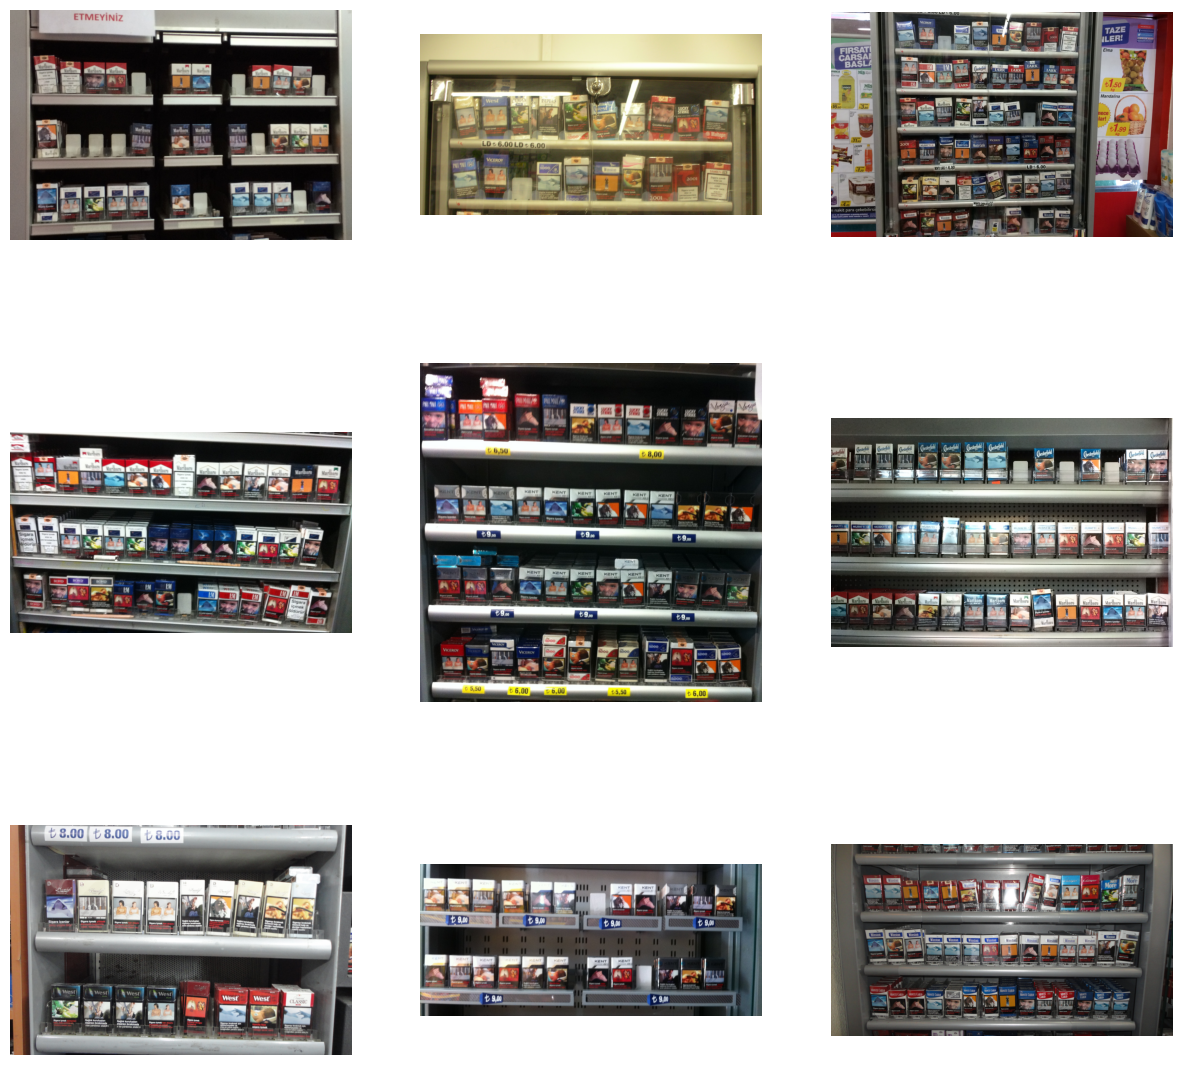

In [5]:
train_images = list(paths.list_images("ShelfImages/train"))
plt.figure(figsize=(15, 15))
for i, image  in enumerate(train_images[:9]):
    image = plt.imread(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

- A question that gets raised here - how do I map these images to their detection annotations? From [here](https://github.com/gulvarol/grocerydataset#annotationtxt) we have the following information (which is summarized in [`annotations.csv`](https://github.com/gulvarol/grocerydataset/blob/master/annotations.csv)) -

### **Visualize bbox annotations**

In [6]:
cols = ["image_name", "x_i", "y_i", "w_i", "h_i", "b_i"]
master_df = pd.read_csv("https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv",
                        names=cols)
master_df.head()

,image_name,x_i,y_i,w_i,h_i,b_i
0,C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0
1,C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0
2,C1_P01_N1_S2_1.JPG,24,872,268,1264,0
3,C1_P01_N1_S2_1.JPG,280,1568,532,1944,0
4,C1_P01_N1_S2_1.JPG,292,872,544,1248,0


```
<shelf image name> <n> <x_1> <y_1> <w_1> <h_1> <b_1> <x_2> <y_2> <w_2> <h_2> <b_2> ... <x_n> <y_n> <w_n> <h_n> <b_n>
    where
        <shelf image name>   := shelf image name
        <n>                  := number of product on the shelf image
        <x_i>                := x-coordinate of the i'th product image
        <y_i>                := y-coordinate of the i'th product image
        <w_i>                := width of the i'th product image
        <h_i>                := height of the i'th product image
        <b_i>                := brand of the i'th product image
```

In [7]:
# How many unique brands? (0 stands for "other" class)

master_df["b_i"].unique()

array([ 0,  1,  4,  7,  3,  6, 10,  2,  5,  8,  9])

- Let's visualize a few images with their respective annotations. We will write a small utility for this purpose.

In [8]:
def vis_annotations(image_path: str, coordinate_list: List[List[int]],
                    color: str="blue") -> None:
    """Converts bounding box to matplotlib format, imposes it on the
    provided image and then displays the plot."""
    image = plt.imread(image_path)
    fig = plt.imshow(image)
    for i in range(len(coordinate_list)):
        bbox = coordinate_list[i]
        fig.axes.add_patch(plt.Rectangle(
            xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
            fill=False, edgecolor=color, linewidth=2))
    plt.show()

- Let's start with the first image from the dataframe above. Its absolute path is present in `train_images`.

In [9]:
train_images[0]

'ShelfImages/train/C1_P11_N1_S3_2.JPG'

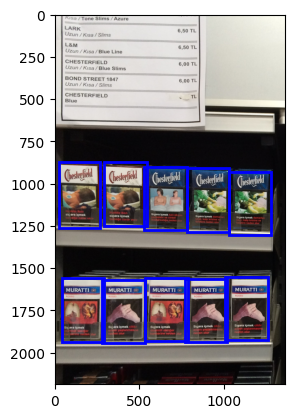

In [10]:
coordinate_columns = master_df.columns[1:-1]
coordinate_list = master_df[master_df["image_name"]=="C1_P01_N1_S2_1.JPG"][coordinate_columns]
coordinate_list = coordinate_list.values.tolist()
vis_annotations("ShelfImages/train/C1_P01_N1_S2_1.JPG", coordinate_list)

### **Splitting into train and test dataframes**

**We already have the train and test images segregated. We can use that information to split `master_df` into train and test dataframes.**

In [11]:
# Grab the image names belonging to the train and test sets
train_images = list(paths.list_images("ShelfImages/train"))
test_images = list(paths.list_images("ShelfImages/test"))
train_image_names = [image_path.split("/")[-1] for image_path in train_images]
test_image_names = [image_path.split("/")[-1] for image_path in test_images]
print(len(train_image_names), len(test_image_names))

283 71


In [12]:
# Create two different dataframes from train and test sets
train_df = master_df[master_df["image_name"].isin(train_image_names)]
test_df = master_df[~master_df["image_name"].isin(train_image_names)]
print(len(np.unique(train_df["image_name"])), len(np.unique(test_df["image_name"])))

283 71


In [13]:
# Let's turn the image names into absolute paths
train_df["image_name"] = train_df["image_name"].map(lambda x: "ShelfImages/train/" + x)
test_df["image_name"] = test_df["image_name"].map(lambda x: "ShelfImages/test/" + x)

<ipython-input-13-5339d736f7f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["image_name"] = train_df["image_name"].map(lambda x: "ShelfImages/train/" + x)
<ipython-input-13-5339d736f7f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["image_name"] = test_df["image_name"].map(lambda x: "ShelfImages/test/" + x)


In [14]:
# Preview
train_df.head()

,image_name,x_i,y_i,w_i,h_i,b_i
0,ShelfImages/train/C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0
1,ShelfImages/train/C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0
2,ShelfImages/train/C1_P01_N1_S2_1.JPG,24,872,268,1264,0
3,ShelfImages/train/C1_P01_N1_S2_1.JPG,280,1568,532,1944,0
4,ShelfImages/train/C1_P01_N1_S2_1.JPG,292,872,544,1248,0


### **Setup TFOD API**

In [25]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

!git clone https://github.com/tensorflow/models.git

%cd models/research
!pip install --upgrade pip

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf1/setup.py .
!python -m pip install --use-feature=2020-resolver .

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2

Usage:   
  /usr/bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /usr/bin/python3 -m pip install [options] [-e] <local project path> ...
  /usr/bin/python3 -m pip install [options] <archive url/path> ...

option --use-feature: invalid choice: '2020-resolver' (choose from 'fast-deps', 'truststore', 'no-binary-enable-wheel-cache')


### **Generating TFRecords**

We will be using the [TFOD API](https://github.com/tensorflow/models/tree/master/research/object_detection) to train the detection model. The API expects TFRecords as its inputs. So, before we start the model training process we first need to represent our dataset in terms of TFRecords only.

A single example inside the TFRecords should have the following entries -
* filename,
* width,
* height,
* class,
* xmin,
* ymin,
* xmax,
* ymax

**Note**: Although the official repository of the Grocery Dataset mentions that there are width and height coordinates I don't they are so. I think they are bottom-right coordinates. Also, TFOD API reserves 0 for the background label. Therefore, we will add 1 to all the brand IDs.

Given all of these, let's start by writing a utility to create our dataframes in the expected format.

In [26]:
def prepare_df(original_df):
    df = pd.DataFrame()
    df["filename"] = original_df["image_name"]
    df["wdith"] = (original_df["x_i"] - original_df["w_i"]).astype("int")
    df["height"] = (original_df["y_i"] - original_df["h_i"]).astype("int")
    df["class"] = (original_df["b_i"] + 1).astype("int")
    df["xmin"] = (original_df["x_i"]).astype("int")
    df["ymin"] = (original_df["y_i"]).astype("int")
    df["xmax"] = (original_df["w_i"]).astype("int")
    df["ymax"] = (original_df["h_i"]).astype("int")
    return df

In [27]:
new_train_df = prepare_df(train_df)
new_test_df = prepare_df(test_df)
print(len(np.unique(new_train_df["filename"])), len(np.unique(new_test_df["filename"])))

283 71


In [28]:
# Serialize these dataframes

new_train_df.to_csv("train.csv", index=False)
new_test_df.to_csv("test.csv", index=False)

In [29]:
!ls -lh *.csv

-rw-r--r-- 1 root root 172K Aug 23 19:23 test.csv
-rw-r--r-- 1 root root 693K Aug 23 19:23 train.csv


- I wrote this [utility script](https://gist.github.com/sayakpaul/d82a43c03089a8abfb5b042ee89eeb32) to help us generate the TFRecords.

In [30]:
!wget -q -O generate_tfrecord.py https://gist.githubusercontent.com/sayakpaul/d82a43c03089a8abfb5b042ee89eeb32/raw/fee76357235803c6a0d2d8859e72542c7a916340/generate_tfrecord.py

In [31]:
!python generate_tfrecord.py \
    --csv_input=/content/models/research/train.csv \
    --output_path=/content/train.record
!python generate_tfrecord.py \
    --csv_input=/content/models/research/test.csv \
    --output_path=/content/test.record

!ls -lh *.record

2023-08-23 19:24:23.980864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/models/research/generate_tfrecord.py", line 23, in <module>
    flags = tf.app.flags
AttributeError: module 'tensorflow' has no attribute 'app'
2023-08-23 19:24:30.117829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/models/research/generate_tfrecord.py", line 23, in <module>
    flags = tf.app.flags
AttributeError: module 'tensorflow' has no attribute 'app'
ls: cannot access '*.record': No such file or directory


### **Generate `.pbtxt`**

We need to generate a `.pbtxt` file that defines a mapping between our classes and integers. In our case, the classes are already integers. But we still need this file for the TFOD API to operate.

In [32]:
classes = new_train_df["class"].unique()
label_encodings = {}
for cls in classes:
    label_encodings[str(cls)] = int(cls)

f = open("/content/label_map.pbtxt", "w")

for (k, v) in label_encodings.items():
    item = ("item {\n"
            "\tid: " + str(v) + "\n"
            "\tname: '" + k + "'\n"
            "}\n")
    f.write(item)

f.close()

!cat /content/label_map.pbtxt

item {
	id: 1
	name: '1'
}
item {
	id: 2
	name: '2'
}
item {
	id: 5
	name: '5'
}
item {
	id: 8
	name: '8'
}
item {
	id: 4
	name: '4'
}
item {
	id: 7
	name: '7'
}
item {
	id: 11
	name: '11'
}
item {
	id: 3
	name: '3'
}
item {
	id: 6
	name: '6'
}
item {
	id: 9
	name: '9'
}
item {
	id: 10
	name: '10'
}


### **Moving files to Google Drive for later usage**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir /content/drive/MyDrive/product-detection
!cp -r *.record /content/drive/MyDrive/product-detection
!cp -r *.pbtxt /content/drive/MyDrive/product-detection